### Longitudinal predictions for the AML dataset

#### 1. Import libraries and functions

In [3]:
import arviz as az
import numpy as np
from anytree import PreOrderIter
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import seaborn as sns
from fitree import(
	load_cohort_from_json,
	Subclone,
)

#### 2. Load Data

In [4]:
AML_cohort = load_cohort_from_json("AML_cohort_Morita_2020.json")


In [5]:
AML_combined_traces = az.from_netcdf("AML_combined_traces.nc")

In [6]:
rng = np.random.default_rng(123)
n_samples = 1000
AML_combined_traces = AML_combined_traces.posterior.stack(samples=["chain", "draw"])
sampled_traces = AML_combined_traces.isel(samples=rng.choice(AML_combined_traces.samples.size, n_samples, replace=False))
F_mat_samples = sampled_traces.fitness_matrix.values

In [7]:
mutation_set = AML_cohort.get_observed_mutations()

#### 3. Helper functions

In [8]:
def get_possible_mutations(node: Subclone, mutation_set: set) -> set[int]:
    """This function returns a set of all mutations of the given node,
    as well as its parent and children.
    """
    mutations = set(node.get_genotype())
    for child in node.children:
        mutations.update(child.mutation_ids)

    return mutation_set.difference(mutations)

def get_pathway(leaf: Subclone, mutation_labels: list) -> str:
    path = ""
    current_node = leaf
    while not current_node.is_root:
        mut = mutation_labels[current_node.mutation_ids[0]] # pyright: ignore
        path = f"->{mut}{path}"
        current_node = current_node.parent

    path = f"Root{path}"
    return path

def get_predictions(
    tree: Subclone,
    mutation_set: set,
    mutation_labels: list,
    mu_vec: np.ndarray,
    F_mat: np.ndarray,
    common_beta: float = 1.0,
    max_level: int | None = None,
) -> pd.DataFrame:
    
    rows = []

    tree_ = deepcopy(tree)
    # loop through all nodes in the tree
    all_nodes = list(PreOrderIter(tree_, maxlevel=max_level))
    for node in all_nodes:

        # update growth parameters for the node
        if not node.is_root:
            node.get_growth_params(mu_vec, F_mat, common_beta)

        possible_mutations = get_possible_mutations(node, mutation_set)
        for j in possible_mutations:
            new_node = Subclone(
                node_id=tree_.size,
                mutation_ids=[j],
                seq_cell_number=0,
                parent=node,
            )
            growth_params = new_node.get_growth_params(mu_vec, F_mat, common_beta, return_dict=True)
            
            # add a new row to the dataframe
            new_row = {
                "pathway": get_pathway(new_node, mutation_labels),
                "parent_size": new_node.parent.cell_number,
                "mutation_rate": growth_params["nu"],
                "lambda": growth_params["lam"],
                "delta": growth_params["delta"],
            }
            rows.append(new_row)
          
    predictions = pd.DataFrame(rows)
    predictions["rate"] = predictions["parent_size"] * predictions["mutation_rate"] * predictions["delta"]
    predictions["rank"] = predictions["rate"].rank(pct=True)

    return predictions


In [20]:
# Set global Seaborn theme to white
sns.set_theme(style="white")

def plot_rank_density(
    ax,
    ranks, 
    TreeMHN_rank, 
    REVOLVER_rank,
    CloMu_rank,
    title
):
    # Define color palette with a softer, modern touch
    colors = {
        "FiTree": "#fac748",  
        "TreeMHN": "#9bc53d", 
        "REVOLVER": "#8390fa", 
        "CloMu": "grey",
    }

    # Ensure the subplot background is white
    ax.set_facecolor("white")

    # KDE plot with more elegant aesthetics
    sns.kdeplot(
        ranks, color=colors["FiTree"], label="FiTree posterior", 
        linewidth=2, fill=True, alpha=0.4, bw_adjust=1.0, ax=ax, 
        clip=(0, 1)
    )

    # Vertical lines with matching colors and better formatting
    ax.axvline(np.median(ranks), color=colors["FiTree"], linestyle="-", linewidth=3, label="FiTree median")
    ax.axvline(TreeMHN_rank, color=colors["TreeMHN"], linestyle="-.", linewidth=3, label="TreeMHN")
    ax.axvline(REVOLVER_rank, color=colors["REVOLVER"], linestyle=":", linewidth=3, label="REVOLVER")
    ax.axvline(CloMu_rank, color=colors["CloMu"], linestyle="--", linewidth=3, label="CloMu")


    ax.set_xlabel("")
    ax.set_xticks([0.25, 0.5, 0.75, 1])
    ax.set_yticks([])  # Remove y-axis
    ax.set_ylabel("")

    ax.set_title(title, fontsize=12, pad=16)

    # Minimalist grid with subtle visibility
    ax.grid(True, linestyle=":", alpha=0.8)

    # Add border
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(1)

    
def plot_rank_densities(
    ranks_list,
    TreeMHN_ranks,
    REVOLVER_ranks,
    CloMu_ranks,
    titles,
    figsize=(16, 6),
):
    fig, axs = plt.subplots(4, 1, figsize=figsize, sharey=False, sharex=False)

    axs = axs.flatten()
    
    # Ensure entire figure background is white
    fig.patch.set_facecolor("white")

    for ax, ranks, TreeMHN_rank, REVOLVER_rank, CloMu_rank, title in zip(axs, ranks_list, TreeMHN_ranks, REVOLVER_ranks, CloMu_ranks, titles):
        plot_rank_density(ax, ranks, TreeMHN_rank, REVOLVER_rank, CloMu_rank, title)
        ax.set_facecolor("white")  # Set subplot background to white

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.1), frameon=False)  # Add legend
    # fig.legend(handles, labels, loc="center right", fontsize=14, bbox_to_anchor=(1.5, 0.5), frameon=False)  # Add legend

    # remove legend border


    fig.text(0.5, -0.02, "Percentile Rank", fontsize=16, ha="center")

    plt.tight_layout()

    # Ensure saved figure background is white
    


#### 4. Evaluation on patients

##### AML-04-001

In [10]:
tree_idx = AML_cohort.tree_labels.index("AML-04-001")
tree = AML_cohort.trees[tree_idx]

In [11]:
ranks_04_1 = np.zeros(1000)
ranks_04_2 = np.zeros(1000)
for i in range(1000):
    pred = get_predictions(
        tree.root, 
        mutation_set, 
        AML_cohort.mutation_labels,
        AML_cohort.mu_vec, 
        F_mat_samples[:,:,i], 
        common_beta=1.0
    )
    ranks_04_1[i] = pred.query(f"pathway == 'Root->SF3B1->SRSF2->NRAS->WT1'")["rank"].astype(float).values[0]
    ranks_04_2[i] = pred.query(f"pathway == 'Root->SF3B1->SRSF2->IDH1'")["rank"].astype(float).values[0]

##### AML-09-001

In [12]:
tree_idx = AML_cohort.tree_labels.index("AML-09-001")
tree = AML_cohort.trees[tree_idx]

In [13]:
ranks_09 = np.zeros(1000)
for i in range(1000):
    pred = get_predictions(
        tree.root, 
        mutation_set, 
        AML_cohort.mutation_labels,
        AML_cohort.mu_vec, 
        F_mat_samples[:,:,i], 
        common_beta=1.0
    )
    ranks_09[i] = pred.query(f"pathway == 'Root->NPM1->FLT3->WT1'")["rank"].astype(float).values[0]

##### AML-83-001

In [14]:
tree_idx = AML_cohort.tree_labels.index("AML-83-001")
tree = AML_cohort.trees[tree_idx]

In [15]:
ranks_83 = np.zeros(1000)
for i in range(1000):
    pred = get_predictions(
        tree.root, 
        mutation_set, 
        AML_cohort.mutation_labels,
        AML_cohort.mu_vec, 
        F_mat_samples[:,:,i], 
        common_beta=1.0
    )
    ranks_83[i] = pred.query(f"pathway == 'Root->DNMT3A->IDH2->NRAS'")["rank"].astype(float).values[0]

In [16]:
ranks_list = [ranks_04_1, ranks_04_2, ranks_09, ranks_83]
TreeMHN_ranks = [0.7364, 0.7023, 0.9569, 0.9716] # obtained from the TreeMHN paper (Luo et al., 2023)
REVOLVER_ranks = [0.3591, 0.8341, 1.0, 0.9545] # obtained from the TreeMHN paper (Luo et al., 2023)
CloMu_ranks = [0.6936, 0.3873, 0.3333, 0.9672] # obtained from a separate analysis (see CloMu_predictions.ipynb)

titles = [
    "AML-04-001\nRoot$\\rightarrow$SF3B1$\\rightarrow$SRSF2$\\rightarrow$NRAS$\\rightarrow$WT1",
    "AML-04-001\nRoot$\\rightarrow$SF3B1$\\rightarrow$SRSF2$\\rightarrow$IDH1",
    "AML-09-001\nRoot$\\rightarrow$NPM1$\\rightarrow$FLT3$\\rightarrow$WT1",
    "AML-83-001\nRoot$\\rightarrow$DNMT3A$\\rightarrow$IDH2$\\rightarrow$NRAS",
]

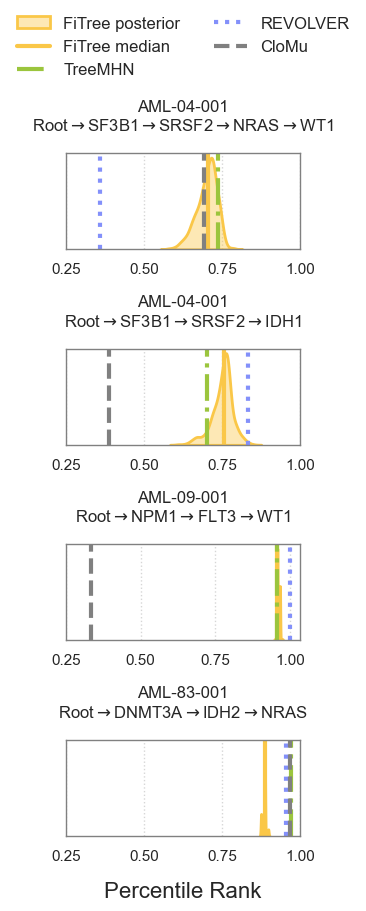

In [ ]:
plot_rank_densities(ranks_list, TreeMHN_ranks, REVOLVER_ranks, CloMu_ranks, titles, figsize=(3, 8))
plt.show()